## Notebook Submission Template

This notebook is one of the mandatory deliverables when you submit your solution. Its structure follows the WDL evaluation criteria and it has dedicated cells where you should add information. Make sure your code is readable as it will be the only technical support the jury will have to evaluate your work. Make sure to list all the datasets used besides the ones provided.

Instructions:
1. 🧱 Create a separate copy of this template and **do not change** the predefined structure
2. 👥 Fill in the Authors section with the name of each team member
3. 💻 Develop your code - make sure to add comments and save all the output you want the jury to see. Your code **must be** runnable!
4. 📄 Fill in all the text sections
5. 🗑️ Remove this section (‘Notebook Submission Template’) and any instructions inside other sections
6. 📥 Export as HTML and make sure all the visualisations are visible.
7. ⬆️ Upload the .ipynb file to the submission platform.


## 🎯 Challenge
Predict Waste Production for its Reduction


## 👥 Authors

* Claire Benard
* Diego Arenas
* Natalie Muenter
* Tom Constant
* Tom Wagstaff


## 💻 Development
Start coding here! 🐱‍🏍

Create the necessary subsections (e.g. EDA, different experiments, etc..) and markdown cells to include descriptions of your work where you see fit. Comment your code. 

All new subsections must start with three hash characters.

Pro-tip 1: Don't forget to make the jury's life easier. Remove any unnecessary prints before submitting the work. Hide any long output cells (from training a model for example). For each subsection, have a quick introduction (justifying what you are about to do) and conclusion (results you got from what you did). 

Pro-tip 2: Have many similiar graphs which all tell the same story? Add them to the appendix and show only a couple of examples, with the mention that all the others are in the appendix.

### 🦺 Set up

In [3]:
import pandas as pd
from datetime import datetime
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_plotly, plot_components_plotly
import matplotlib.pyplot as plt


%matplotlib inline



Bad key "text.kerning_factor" on line 4 in
/Users/nmm/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


### 🧼 Data import and cleaning

Let's import the **clean data**. Details of how the data was cleaned are available in the appendix but here is a summary of the issues we identified and the decisions we made:

1) The dataset was supposed to have `Load.ID` has a primary key, it wasn't the case so we removed duplicates and selected the first row of groups that shared a `Load.ID` (44 rows)

2) We removed rows with `Load.Weight` missing. 99.6% of them were in `SWEEPING` which we removed from the analysis anyway 

3) The time series is incomplete for some load types. We kept data from **2005** 

4) `Load.Type` categories don't seem mutually exclusive.

This could be because over time, recycling streams got split into different categories or the data collection process changed over time. We kept the categories making up most of the waste, namely: **Brush, Bulk, Dead animal, Garbage collections, Litter, Mixed Litter, Recycled Metal, Recycling - single stream, Tires and Yard Trimming.**

5) There were some data errors and extreme values that needed to be removed from the analysis. We used an **isolation forest** to identify outliers

6) We grouped the data by day, load type and route number

7) Merged in the population data

In [38]:
data = pd.read_csv('../data/clean_data_CB.csv')
data.head(20)

,date,year,month,wday,Load.Type,Route.Type,Dropoff.Site,Route.Number,outlier,total_pop,annualised_growth,gdp,nb_loads,daily_weight
0,03/01/2005,2005,1,Mon,BRUSH,BRUSH,HORNSBY BEND,BR05,outlier,700407,1.20%,69658.104,3,17400.0
1,03/01/2005,2005,1,Mon,BRUSH,BRUSH,HORNSBY BEND,BRPN01,outlier,700407,1.20%,69658.104,1,3140.0
2,03/01/2005,2005,1,Mon,BRUSH,BRUSH,HORNSBY BEND,BRPS01,outlier,700407,1.20%,69658.104,1,5640.0
3,03/01/2005,2005,1,Mon,BULK,BULK,STEINER LANDFILL,BU27,normal,700407,1.20%,69658.104,1,4620.0
4,03/01/2005,2005,1,Mon,BULK,BULK,TDS LANDFILL,BU27,outlier,700407,1.20%,69658.104,6,69380.0
5,03/01/2005,2005,1,Mon,DEAD ANIMAL,DEAD ANIMAL,TDS LANDFILL,DA01,outlier,700407,1.20%,69658.104,1,1080.0
6,03/01/2005,2005,1,Mon,GARBAGE COLLECTIONS,GARBAGE COLLECTION,TDS LANDFILL,PAM01,normal,700407,1.20%,69658.104,2,37400.0
7,03/01/2005,2005,1,Mon,GARBAGE COLLECTIONS,GARBAGE COLLECTION,TDS LANDFILL,PAM02,normal,700407,1.20%,69658.104,1,17960.0
8,03/01/2005,2005,1,Mon,GARBAGE COLLECTIONS,GARBAGE COLLECTION,TDS LANDFILL,PAM03,normal,700407,1.20%,69658.104,2,29100.0
9,03/01/2005,2005,1,Mon,GARBAGE COLLECTIONS,GARBAGE COLLECTION,TDS LANDFILL,PAM04,normal,700407,1.20%,69658.104,1,20960.0


In [39]:
data['date'] = data['date'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y'))

In [40]:
data['waste_by_person'] = data.daily_weight/data.total_pop

### Modeling

In [41]:
filtered_data = data[(((data['Load.Type'] == "GARBAGE COLLECTIONS") & (data['Route.Type'] == "GARBAGE COLLECTION")) |
                      ((data['Load.Type'] == "RECYCLING - SINGLE STREAM") & (data['Route.Type'] == "RECYCLING - SINGLE STREAM"))) &
                      (data['outlier'] == "normal")  
                     & (data['year']>2010) ]

In [42]:
df_gc = filtered_data[filtered_data['Load.Type'] == "GARBAGE COLLECTIONS"].groupby(['date'])['waste_by_person'].sum().reset_index()

df_gc.columns = ['ds', 'y']
df_gc = df_gc[df_gc.y > 0.5] 
df_gc_train = df_gc[df_gc.ds < '2020-01-01']
df_gc_test = df_gc[df_gc.ds >= '2020-01-01']

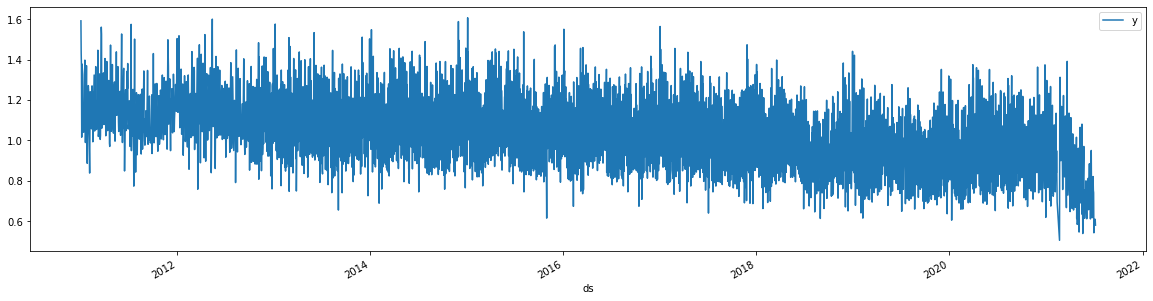

In [43]:
df_gc.plot(x ='ds', y='y', kind = 'line',figsize=(20, 5))

Fiting a prophet model just for Garbage Collection load type

In [44]:
m_gc = Prophet()
m_gc.fit(df_gc_train)
future_gc = m_gc.make_future_dataframe(periods=365*2)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [45]:
forecast_gc = m_gc.predict(future_gc)
forecast_gc[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail();

In [46]:
plot_plotly(m_gc, forecast_gc)

/Users/nmm/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



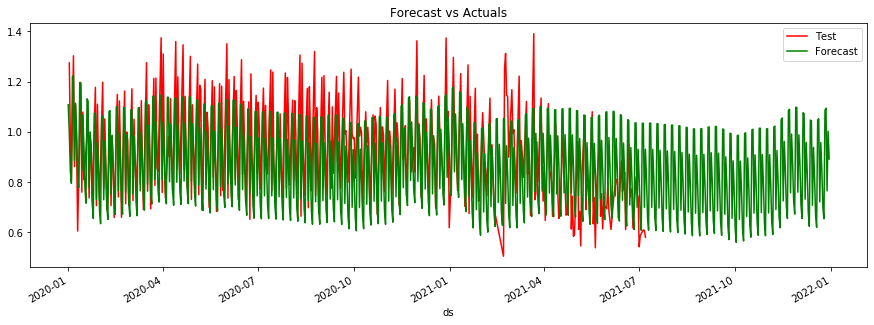

In [47]:
df_gc_test.ds = pd.to_datetime(df_gc_test.ds)
predictions = pd.DataFrame(forecast_gc[-365*2:])
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
df_gc_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
predictions.plot(kind='line', x='ds', y='yhat', color='green', label='Forecast', ax=ax)
plt.title('Forecast vs Actuals')
plt.show()

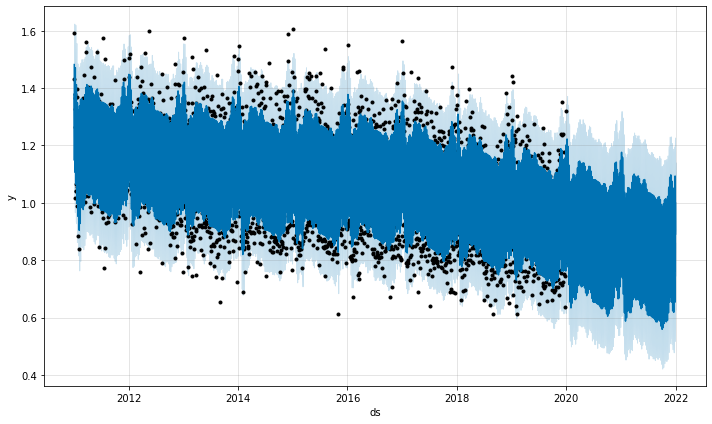

In [48]:
fig1_gc = m_gc.plot(forecast_gc)

In [49]:
#following https://facebook.github.io/prophet/docs/diagnostics.html#cross-validation
df_cv = cross_validation(m_gc, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

INFO:prophet:Making 13 forecasts with cutoffs between 2013-01-31 00:00:00 and 2018-12-31 00:00:00


  0%|          | 0/13 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,0.014800,0.121655,0.093961,0.097513,0.074233,0.093881,0.790560
1,38 days,0.014594,0.120806,0.093024,0.096546,0.072851,0.092981,0.789454
2,39 days,0.014247,0.119359,0.091695,0.095875,0.070264,0.092187,0.793510
3,40 days,0.014096,0.118726,0.091238,0.095750,0.070264,0.091805,0.794494
4,41 days,0.014689,0.121198,0.092825,0.097693,0.070404,0.093361,0.788201


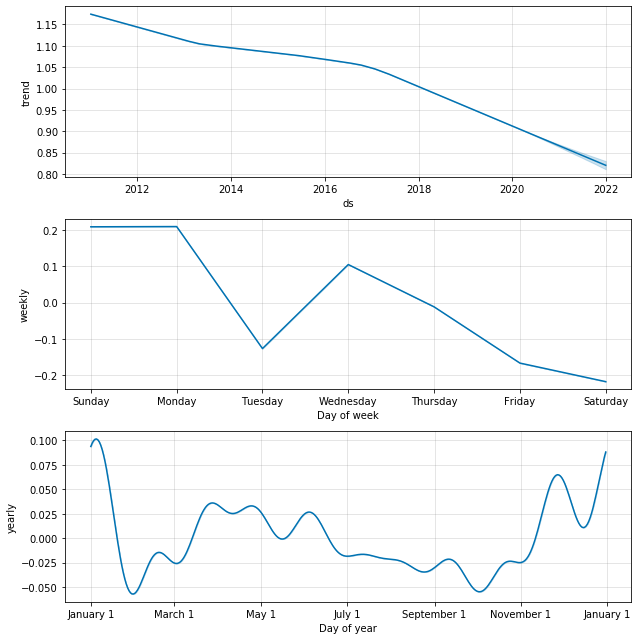

In [50]:
fig2_gc = m_gc.plot_components(forecast_gc)

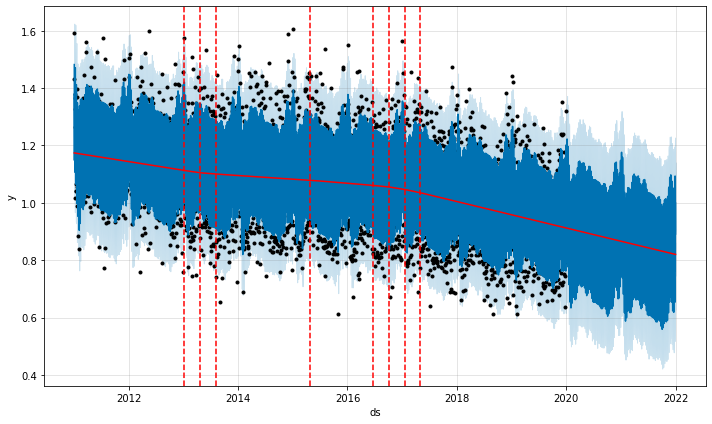

In [51]:
a = add_changepoints_to_plot(fig1_gc.gca(),m_gc,forecast_gc)
fig1_gc

for Recycling WIP

In [52]:
df_rec = filtered_data[filtered_data['Load.Type'] == "RECYCLING - SINGLE STREAM"].groupby('date')['waste_by_person'].sum().reset_index()
df_rec.columns = ['ds', 'y']
df_rec = df_rec[df_rec.y > 0.2]
df_rec_train = df_rec[df_rec.ds < '2019-01-01']
df_rec_test = df_rec[df_rec.ds >= '2019-01-01']


In [53]:
m_rec = Prophet()
m_rec.fit(df_rec_train);
future_rec = m_rec.make_future_dataframe(periods=365*3);

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [54]:
forecast_rec = m_rec.predict(future_rec)
forecast_rec[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail();

In [55]:
plot_plotly(m_rec, forecast_rec)

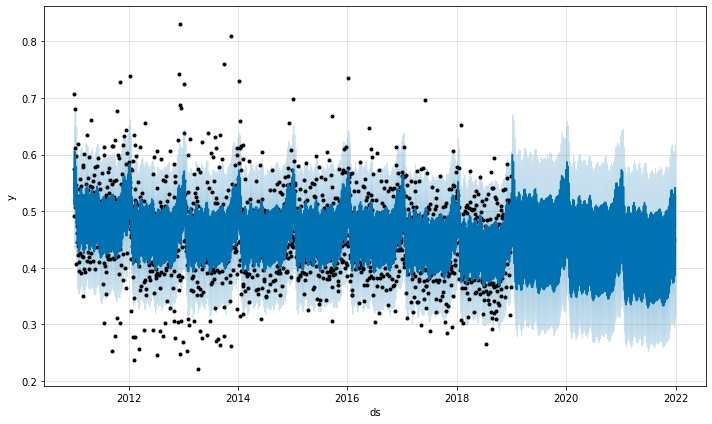

In [56]:
fig1_rec = m_rec.plot(forecast_rec)

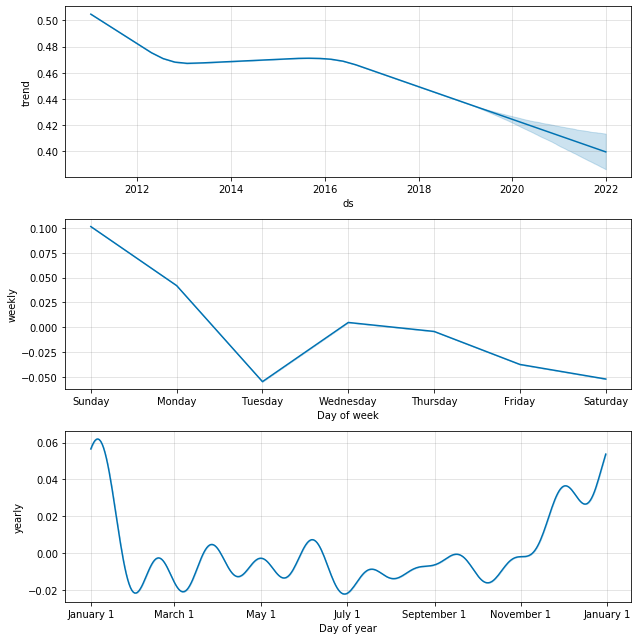

In [57]:
fig2_rec = m_rec.plot_components(forecast_rec)

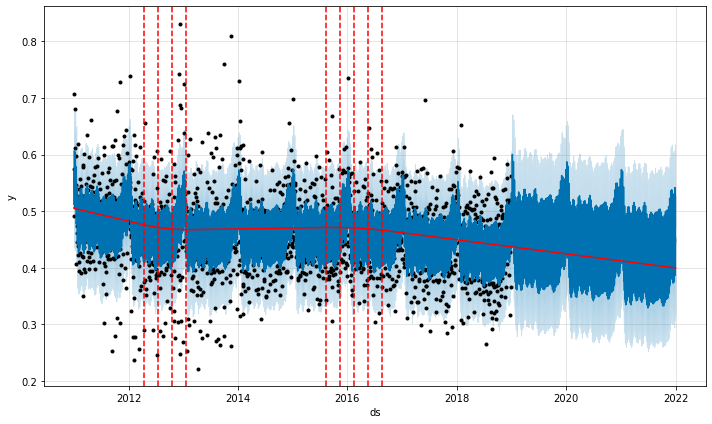

In [58]:

a = add_changepoints_to_plot(fig1_rec.gca(),m_rec,forecast_rec)
fig1_rec

/Users/nmm/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



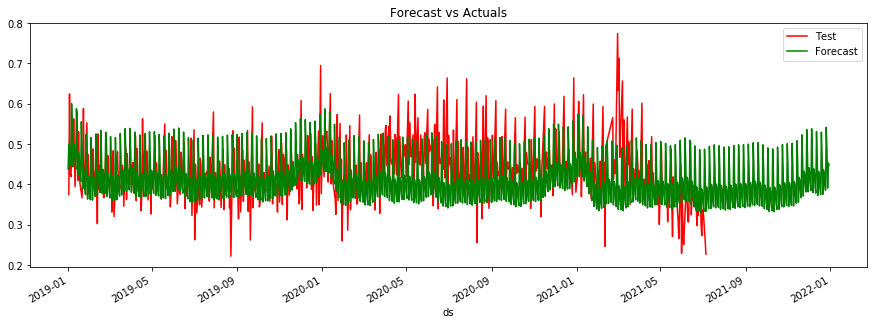

In [59]:
df_rec_test.ds = pd.to_datetime(df_rec_test.ds)
predictions = pd.DataFrame(forecast_rec[-365*3:])
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
df_rec_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
predictions.plot(kind='line', x='ds', y='yhat', color='green', label='Forecast', ax=ax)
plt.title('Forecast vs Actuals')
plt.show()

## 🖼️ Visualisations
Copy here the most important visualizations (graphs, charts, maps, images, etc). You can refer to them in the Executive Summary.

Technical note: If not all the visualisations are visible, you can still include them as an image or link - in this case please upload them to your own repository.

## 👓 References
List all of the external links (even if they are already linked above), such as external datasets, papers, blog posts, code repositories and any other materials.

## ⏭️ Appendix
Add here any code, images or text that you still find relevant, but that was too long to include in the main report. This section is optional.
